In [1]:
import os
import itertools
import numpy as np
import pandas as pd
# PyTorch
import torch
import torchvision
import matplotlib.pyplot as plt
from matplotlib.ticker import NullLocator, NullFormatter
plt.rcParams.update({'font.size': 9})

In [2]:
import sys
sys.path.append('../src/')

%load_ext autoreload
%autoreload 2
# Importing our custom module(s)
import utils as utils
import losses

In [3]:
def flatten_dict_params(params_dict):
    return torch.cat([v.view(-1) if isinstance(v, torch.Tensor) else flatten_dict_params(v) for v in params_dict.values()])

experiments_path = '/cluster/home/eharve06/transfer-learning/experiments/retrained_C'
std_prior_model_names = [
    'StdPrior_lr_0=0.0001_n=1000_random_state=1001_weight_decay=0.0001',
    'StdPrior_lr_0=0.01_n=1000_random_state=2001_weight_decay=1e-05',
    'StdPrior_lr_0=0.01_n=1000_random_state=3001_weight_decay=0.001',
]
learned_prior_iso_model_names = [
    'adapted_lr_0=0.1_n=1000_random_state=1001_weight_decay=0.01', 
    'adapted_lr_0=0.1_n=1000_random_state=2001_weight_decay=0.01', 
    'adapted_lr_0=0.01_n=1000_random_state=3001_weight_decay=1e-05'
]
learned_prior_lr_model_names = [
    'LearnedPriorLR_bb_weight_decay=100.0_clf_weight_decay=0.0_lr_0=0.01_n=1000_random_state=1001', 
    'LearnedPriorLR_bb_weight_decay=100.0_clf_weight_decay=0.001_lr_0=0.1_n=1000_random_state=2001',
    'LearnedPriorLR_bb_weight_decay=10.0_clf_weight_decay=0.001_lr_0=0.1_n=1000_random_state=3001',
]
best_model_names = [
    'LearnedPriorLR_bb_weight_decay=10.0_clf_weight_decay=0.01_lr_0=0.01_n=50000_random_state=1001', 
    'LearnedPriorLR_bb_weight_decay=10.0_clf_weight_decay=0.01_lr_0=0.01_n=50000_random_state=2001', 
    'LearnedPriorLR_bb_weight_decay=10.0_clf_weight_decay=0.01_lr_0=0.01_n=50000_random_state=3001'
]
for std_prior_model_name, best_model_name in zip(std_prior_model_names, best_model_names):
    std_prior_checkpoint = torch.load(f'{experiments_path}/{std_prior_model_name}.pt', map_location=torch.device('cpu'))
    best_checkpoint = torch.load(f'{experiments_path}/{best_model_name}.pt', map_location=torch.device('cpu'))
    std_prior_params = flatten_dict_params(std_prior_checkpoint)
    best_params = flatten_dict_params(best_checkpoint)
    print(torch.sqrt(((std_prior_params-best_params)**2).sum()))
print()
for learned_prior_iso_model_name, best_model_name in zip(learned_prior_iso_model_names, best_model_names):
    learned_prior_iso_checkpoint = torch.load(f'{experiments_path}/{learned_prior_iso_model_name}.pt', map_location=torch.device('cpu'))
    best_checkpoint = torch.load(f'{experiments_path}/{best_model_name}.pt', map_location=torch.device('cpu'))
    learned_prior_iso_params = flatten_dict_params(learned_prior_iso_checkpoint)
    best_params = flatten_dict_params(best_checkpoint)
    print(torch.sqrt(((learned_prior_iso_params-best_params)**2).sum()))
print()
for learned_prior_lr_model_name, best_model_name in zip(learned_prior_lr_model_names, best_model_names):
    learned_prior_lr_checkpoint = torch.load(f'{experiments_path}/{learned_prior_lr_model_name}.pt', map_location=torch.device('cpu'))
    best_checkpoint = torch.load(f'{experiments_path}/{best_model_name}.pt', map_location=torch.device('cpu'))
    learned_prior_lr_params = flatten_dict_params(learned_prior_lr_checkpoint)
    best_params = flatten_dict_params(best_checkpoint)
    print(torch.sqrt(((learned_prior_lr_params-best_params)**2).sum()))

tensor(1111.1556)
tensor(1111.1372)
tensor(1273.3645)

tensor(1114.0059)
tensor(1120.1296)
tensor(1146.7806)

tensor(1112.5520)
tensor(1122.4263)
tensor(1173.9144)


In [4]:
std_prior_dists = [1111.1556, 1111.1372, 1273.3645]
learned_prior_iso_dists = [1114.0059, 1120.1296, 1146.7806]
learned_prior_lr_dists = [1112.5520, 1122.4263, 1173.9144]
sorted_std_prior_dists = [1111.1372,1111.1556, 1273.3645]
sorted_learned_prior_iso_dists = [1120.1296, 1114.0059, 1146.7806]
sorted_learned_prior_lr_dists = [1122.4263, 1112.5520, 1173.9144]

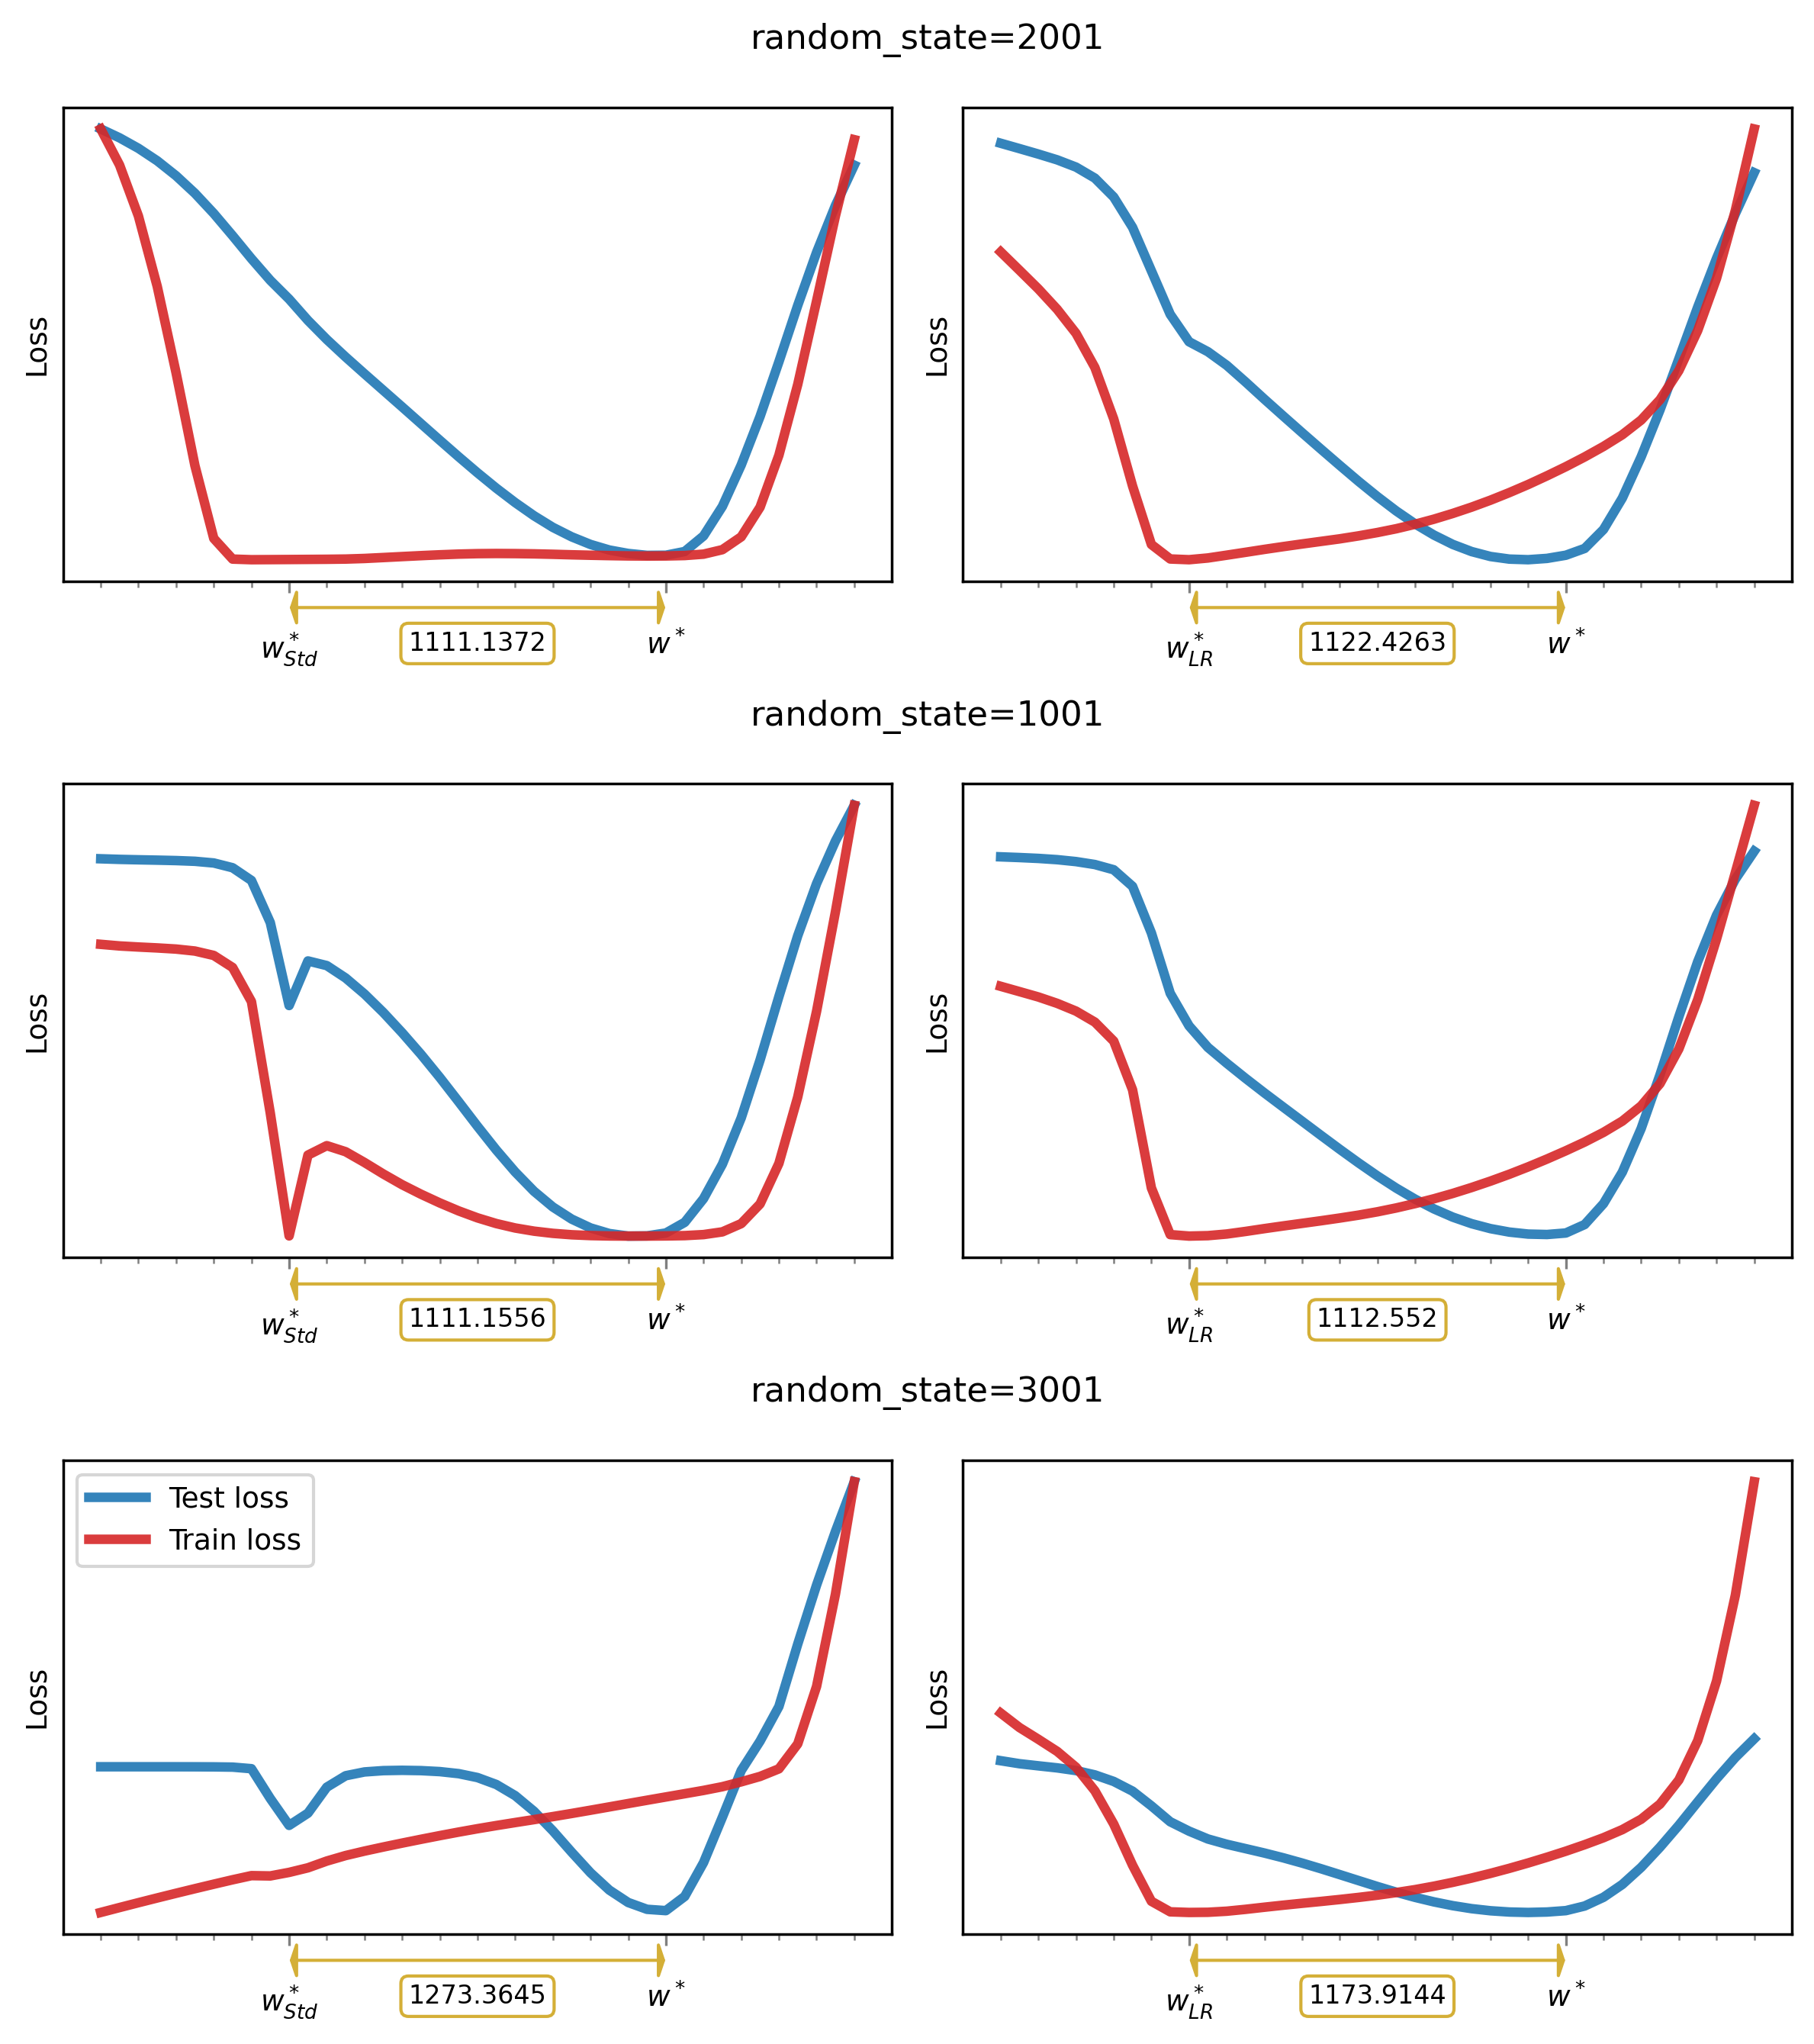

In [5]:
def color_ax(ax, color='gray'):
    ax.spines['bottom'].set_color(color)
    ax.spines['top'].set_color(color)
    ax.spines['left'].set_color(color)
    ax.spines['right'].set_color(color)
    ax.tick_params(which='both', color=color)

def create_subtitle(fig, grid, title):
    row = fig.add_subplot(grid)
    row.set_title(f'{title}\n')
    row.set_frame_on(False)
    row.axis('off')
    
ncols, nrows = 2, 3
fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(4*ncols, 3*nrows), dpi=300)

for index, (random_state, train_label, test_label) in enumerate(zip([2001, 1001, 3001], ['Train loss', None, None], ['Test loss', None, None])):
    
    nonlearned_train_losses = torch.load(f'./nonlearned_train_new_interpolation_random_state={random_state}.pt')
    nonlearned_test_losses = torch.load(f'./nonlearned_test_new_interpolation_random_state={random_state}.pt')
    learned_train_losses = torch.load(f'./learned_train_new_interpolation_random_state={random_state}.pt')
    learned_test_losses = torch.load(f'./learned_test_new_interpolation_random_state={random_state}.pt')

    train_lower_bound = min(min(nonlearned_train_losses), min(learned_train_losses))
    train_upper_bound = max(max(nonlearned_train_losses), max(learned_train_losses))
    test_lower_bound = min(min(nonlearned_test_losses), min(learned_test_losses))
    test_upper_bound = max(max(nonlearned_test_losses), max(learned_test_losses))
        
    logspace = np.logspace(np.log10(test_upper_bound), np.log10(test_lower_bound), num=10)
    logspacing = np.log10(logspace[0]/logspace[1])
        
    start, end = 10, 30

    axs[index,0].plot(range(len(nonlearned_test_losses)), nonlearned_test_losses, alpha=0.9, color='#1f77b4', label=test_label, linewidth=3)
    axs[index,0].scatter(np.argmin(nonlearned_test_losses), test_lower_bound, color='#FFFFFF')
    axs[index,0].scatter(np.argmax(nonlearned_test_losses), test_upper_bound, color='#FFFFFF')
    # Ticks
    axs[index,0].set_xticks([10, 30])
    axs[index,0].set_xticks(np.linspace(0, 40, num=21), minor=True)
    axs[index,0].set_xticklabels([r'$w_{Std}^*$', r'$w^*$'])
    color_ax(axs[index,0])
    axs[index,0].tick_params(axis='x', which='both', pad=12)
    axs[index,0].annotate('', xy=(start-0.4, 10**(np.log10(test_lower_bound)-logspacing)), xycoords='data', textcoords='data', xytext=(end+0.4, 10**(np.log10(test_lower_bound)-logspacing)), arrowprops=dict(arrowstyle="<|-|>", color='#d4af37', mutation_scale=4, mutation_aspect=6), annotation_clip=False)
    axs[index,0].annotate(f'{sorted_std_prior_dists[index]}', xy=((start+end)/2, 10**(np.log10(test_lower_bound)-(7/4*logspacing))), annotation_clip=False, ha='center', va='center', fontsize=8, color='black', bbox=dict(facecolor='white', edgecolor='#d4af37', boxstyle='round,pad=0.3'))
    axs[index,0].set_yscale('log')
    axs[index,0].tick_params(axis='y', which='both', left=False, right=False, labelleft=False, labelright=False)
    axs[index,0].yaxis.set_major_locator(plt.NullLocator())
    axs[index,0].yaxis.set_minor_locator(plt.NullLocator())
    axs[index,0].set_ylabel('Loss')

    twin_axs0 = axs[index,0].twinx()
    twin_axs0.plot(range(len(nonlearned_train_losses)), nonlearned_train_losses, alpha=0.9, color='#d62728', label=train_label, linewidth=3)
    twin_axs0.set_yscale('log')
    twin_axs0.tick_params(axis='y', which='both', left=False, right=False, labelleft=False, labelright=False)

    axs[index,1].plot(range(len(learned_test_losses)), learned_test_losses, alpha=0.9, color='#1f77b4', linewidth=3)
    axs[index,1].scatter(np.argmin(learned_test_losses), test_lower_bound, color='#FFFFFF')
    axs[index,1].scatter(np.argmax(learned_test_losses), test_upper_bound, color='#FFFFFF')
    # Ticks
    axs[index,1].set_xticks([10, 30])
    axs[index,1].set_xticks(np.linspace(0, 40, num=21), minor=True)
    axs[index,1].set_xticklabels([r'$w_{LR}^*$', r'$w^*$'])
    color_ax(axs[index,1])
    axs[index,1].tick_params(axis='x', which='both', pad=12)
    axs[index,1].annotate('', xy=(start-0.4, 10**(np.log10(test_lower_bound)-logspacing)), xycoords='data', textcoords='data', xytext=(end+0.4, 10**(np.log10(test_lower_bound)-logspacing)), arrowprops=dict(arrowstyle="<|-|>", color='#d4af37', mutation_scale=4, mutation_aspect=6), annotation_clip=False)
    axs[index,1].annotate(f'{sorted_learned_prior_lr_dists[index]}', xy=((start+end)/2, 10**(np.log10(test_lower_bound)-(7/4*logspacing))), annotation_clip=False, ha='center', va='center', fontsize=8, color='black', bbox=dict(facecolor='white', edgecolor='#d4af37', boxstyle='round,pad=0.3'))
    axs[index,1].set_yscale('log')
    axs[index,1].tick_params(axis='y', which='both', left=False, right=False, labelleft=False, labelright=False)
    axs[index,1].yaxis.set_major_locator(plt.NullLocator())
    axs[index,1].yaxis.set_minor_locator(plt.NullLocator())
    axs[index,1].set_ylabel('Loss')

    twin_axs1 = axs[index,1].twinx()
    twin_axs1.plot(range(len(learned_train_losses)), learned_train_losses, alpha=0.9, color='#d62728', linewidth=3)
    twin_axs1.set_yscale('symlog')
    twin_axs1.tick_params(axis='y', which='both', left=False, right=False, labelleft=False, labelright=False)

grid = plt.GridSpec(nrows=nrows, ncols=ncols)
create_subtitle(fig, grid[0,:], f'random_state=2001')
create_subtitle(fig, grid[1,:], f'random_state=1001')
create_subtitle(fig, grid[2,:], f'random_state=3001')
    
fig.legend(loc='upper left', bbox_to_anchor=(0,1), bbox_transform=axs[-1,0].transAxes)
fig.tight_layout()    
plt.savefig('new_interpolations.pdf')
plt.show()

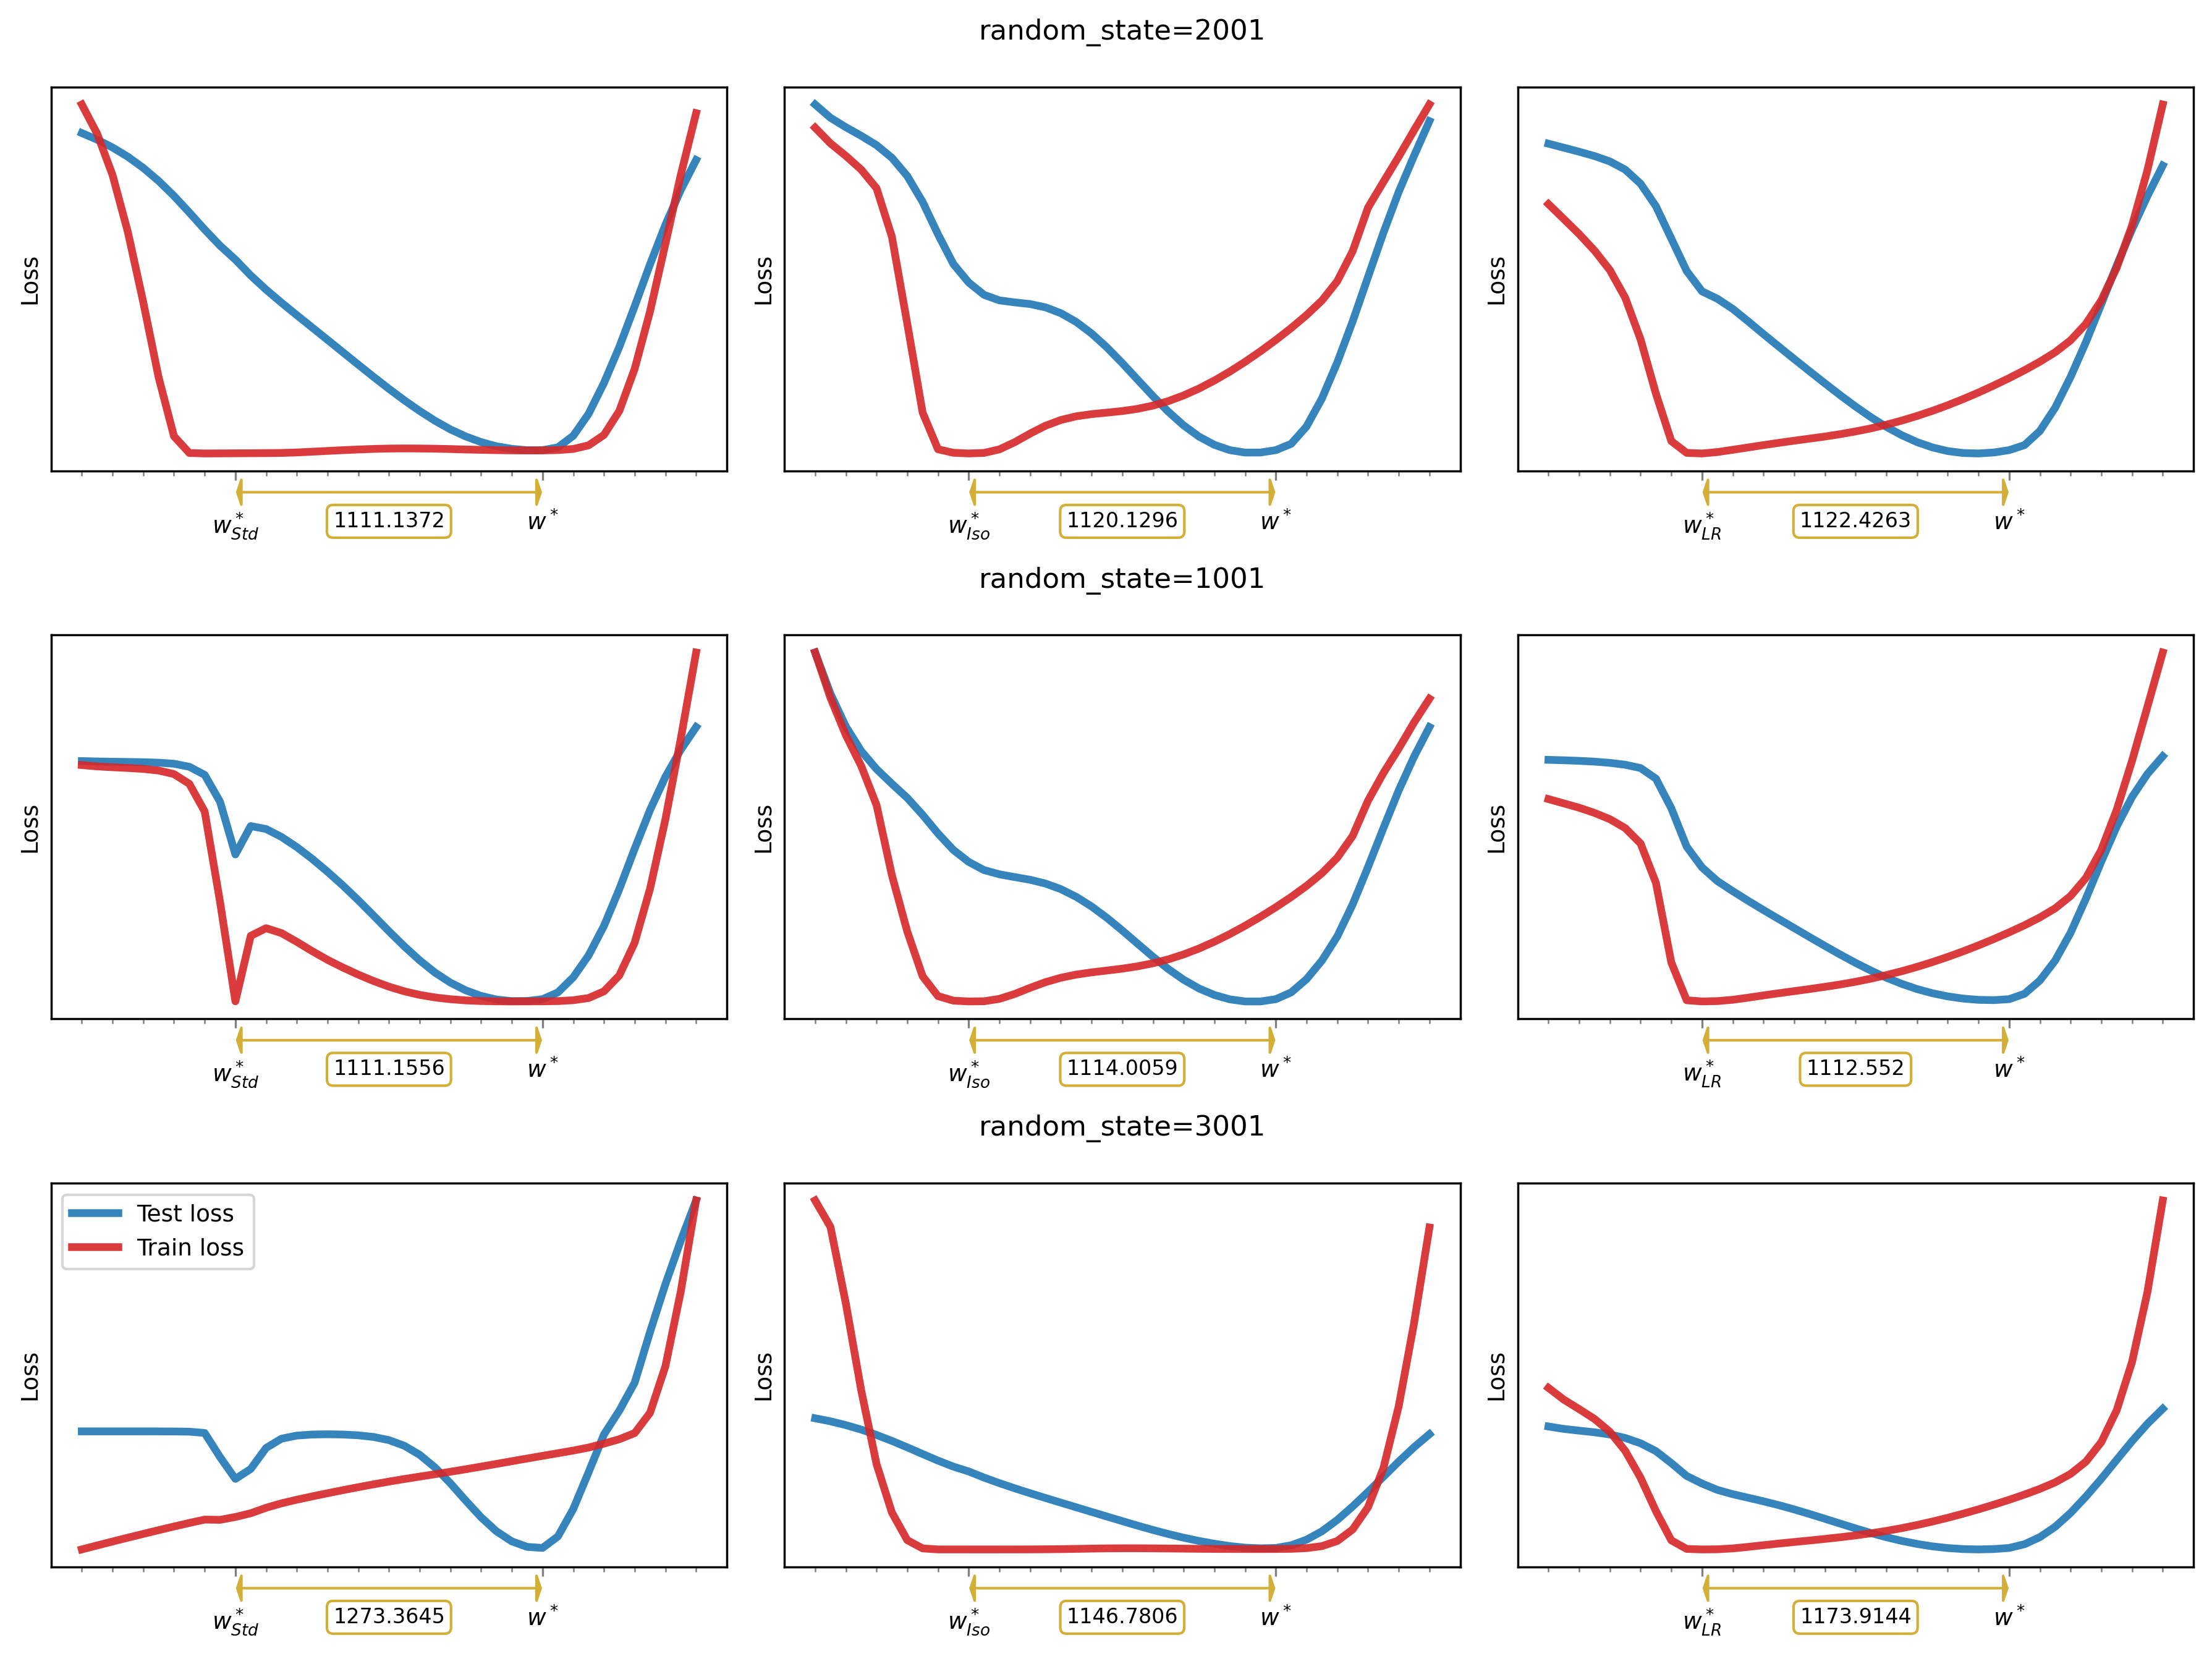

In [6]:
ncols, nrows = 3, 3
fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(4*ncols, 3*nrows), dpi=300)

for index, (random_state, train_label, test_label) in enumerate(zip([2001, 1001, 3001], ['Train loss', None, None], ['Test loss', None, None])):
    
    nonlearned_train_losses = torch.load(f'./nonlearned_train_new_interpolation_random_state={random_state}.pt')
    nonlearned_test_losses = torch.load(f'./nonlearned_test_new_interpolation_random_state={random_state}.pt')
    adapted_train_losses = torch.load(f'./adapted_train_new_interpolation_random_state={random_state}.pt')
    adapted_test_losses = torch.load(f'./adapted_test_new_interpolation_random_state={random_state}.pt')
    learned_train_losses = torch.load(f'./learned_train_new_interpolation_random_state={random_state}.pt')
    learned_test_losses = torch.load(f'./learned_test_new_interpolation_random_state={random_state}.pt')

    train_lower_bound = min(min(nonlearned_train_losses), min(adapted_train_losses), min(learned_train_losses))
    train_upper_bound = max(max(nonlearned_train_losses), max(adapted_train_losses), max(learned_train_losses))
    test_lower_bound = min(min(nonlearned_test_losses), min(adapted_test_losses), min(learned_test_losses))
    test_upper_bound = max(max(nonlearned_test_losses), max(adapted_test_losses), max(learned_test_losses))
        
    logspace = np.logspace(np.log10(test_upper_bound), np.log10(test_lower_bound), num=10)
    logspacing = np.log10(logspace[0]/logspace[1])
        
    start, end = 10, 30

    axs[index,0].plot(range(len(nonlearned_test_losses)), nonlearned_test_losses, alpha=0.9, color='#1f77b4', label=test_label, linewidth=3)
    axs[index,0].scatter(np.argmin(nonlearned_test_losses), test_lower_bound, color='#FFFFFF')
    axs[index,0].scatter(np.argmax(nonlearned_test_losses), test_upper_bound, color='#FFFFFF')
    # Ticks
    axs[index,0].set_xticks([10, 30])
    axs[index,0].set_xticks(np.linspace(0, 40, num=21), minor=True)
    axs[index,0].set_xticklabels([r'$w_{Std}^*$', r'$w^*$'])
    color_ax(axs[index,0])
    axs[index,0].tick_params(axis='x', which='both', pad=12)
    axs[index,0].annotate('', xy=(start-0.4, 10**(np.log10(test_lower_bound)-logspacing)), xycoords='data', textcoords='data', xytext=(end+0.4, 10**(np.log10(test_lower_bound)-logspacing)), arrowprops=dict(arrowstyle="<|-|>", color='#d4af37', mutation_scale=4, mutation_aspect=6), annotation_clip=False)
    axs[index,0].annotate(f'{sorted_std_prior_dists[index]}', xy=((start+end)/2, 10**(np.log10(test_lower_bound)-(7/4*logspacing))), annotation_clip=False, ha='center', va='center', fontsize=8, color='black', bbox=dict(facecolor='white', edgecolor='#d4af37', boxstyle='round,pad=0.3'))
    axs[index,0].set_yscale('log')
    axs[index,0].tick_params(axis='y', which='both', left=False, right=False, labelleft=False, labelright=False)
    axs[index,0].yaxis.set_major_locator(plt.NullLocator())
    axs[index,0].yaxis.set_minor_locator(plt.NullLocator())
    axs[index,0].set_ylabel('Loss')

    twin_axs0 = axs[index,0].twinx()
    twin_axs0.plot(range(len(nonlearned_train_losses)), nonlearned_train_losses, alpha=0.9, color='#d62728', label=train_label, linewidth=3)
    twin_axs0.set_yscale('log')
    twin_axs0.tick_params(axis='y', which='both', left=False, right=False, labelleft=False, labelright=False)

    axs[index,1].plot(range(len(adapted_test_losses)), adapted_test_losses, alpha=0.9, color='#1f77b4', linewidth=3)
    axs[index,1].scatter(np.argmin(adapted_test_losses), test_lower_bound, color='#FFFFFF')
    axs[index,1].scatter(np.argmax(adapted_test_losses), test_upper_bound, color='#FFFFFF')
    # Ticks
    axs[index,1].set_xticks([10, 30])
    axs[index,1].set_xticks(np.linspace(0, 40, num=21), minor=True)
    axs[index,1].set_xticklabels([r'$w_{Iso}^*$', r'$w^*$'])
    color_ax(axs[index,1])
    axs[index,1].tick_params(axis='x', which='both', pad=12)
    axs[index,1].annotate('', xy=(start-0.4, 10**(np.log10(test_lower_bound)-logspacing)), xycoords='data', textcoords='data', xytext=(end+0.4, 10**(np.log10(test_lower_bound)-logspacing)), arrowprops=dict(arrowstyle="<|-|>", color='#d4af37', mutation_scale=4, mutation_aspect=6), annotation_clip=False)
    axs[index,1].annotate(f'{sorted_learned_prior_iso_dists[index]}', xy=((start+end)/2, 10**(np.log10(test_lower_bound)-(7/4*logspacing))), annotation_clip=False, ha='center', va='center', fontsize=8, color='black', bbox=dict(facecolor='white', edgecolor='#d4af37', boxstyle='round,pad=0.3'))
    axs[index,1].set_yscale('log')
    axs[index,1].tick_params(axis='y', which='both', left=False, right=False, labelleft=False, labelright=False)
    axs[index,1].yaxis.set_major_locator(plt.NullLocator())
    axs[index,1].yaxis.set_minor_locator(plt.NullLocator())
    axs[index,1].set_ylabel('Loss')

    twin_axs1 = axs[index,1].twinx()
    twin_axs1.plot(range(len(adapted_train_losses)), adapted_train_losses, alpha=0.9, color='#d62728', linewidth=3)
    twin_axs1.set_yscale('symlog')
    twin_axs1.tick_params(axis='y', which='both', left=False, right=False, labelleft=False, labelright=False)

    axs[index,2].plot(range(len(learned_test_losses)), learned_test_losses, alpha=0.9, color='#1f77b4', linewidth=3)
    axs[index,2].scatter(np.argmin(learned_test_losses), test_lower_bound, color='#FFFFFF')
    axs[index,2].scatter(np.argmax(learned_test_losses), test_upper_bound, color='#FFFFFF')
    # Ticks
    axs[index,2].set_xticks([10, 30])
    axs[index,2].set_xticks(np.linspace(0, 40, num=21), minor=True)
    axs[index,2].set_xticklabels([r'$w_{LR}^*$', r'$w^*$'])
    color_ax(axs[index,2])
    axs[index,2].tick_params(axis='x', which='both', pad=12)
    axs[index,2].annotate('', xy=(start-0.4, 10**(np.log10(test_lower_bound)-logspacing)), xycoords='data', textcoords='data', xytext=(end+0.4, 10**(np.log10(test_lower_bound)-logspacing)), arrowprops=dict(arrowstyle="<|-|>", color='#d4af37', mutation_scale=4, mutation_aspect=6), annotation_clip=False)
    axs[index,2].annotate(f'{sorted_learned_prior_lr_dists[index]}', xy=((start+end)/2, 10**(np.log10(test_lower_bound)-(7/4*logspacing))), annotation_clip=False, ha='center', va='center', fontsize=8, color='black', bbox=dict(facecolor='white', edgecolor='#d4af37', boxstyle='round,pad=0.3'))
    axs[index,2].set_yscale('log')
    axs[index,2].tick_params(axis='y', which='both', left=False, right=False, labelleft=False, labelright=False)
    axs[index,2].yaxis.set_major_locator(plt.NullLocator())
    axs[index,2].yaxis.set_minor_locator(plt.NullLocator())
    axs[index,2].set_ylabel('Loss')

    twin_axs2 = axs[index,2].twinx()
    twin_axs2.plot(range(len(learned_train_losses)), learned_train_losses, alpha=0.9, color='#d62728', linewidth=3)
    twin_axs2.set_yscale('symlog')
    twin_axs2.tick_params(axis='y', which='both', left=False, right=False, labelleft=False, labelright=False)

grid = plt.GridSpec(nrows=nrows, ncols=ncols)
create_subtitle(fig, grid[0,:], f'random_state=2001')
create_subtitle(fig, grid[1,:], f'random_state=1001')
create_subtitle(fig, grid[2,:], f'random_state=3001')
    
fig.legend(loc='upper left', bbox_to_anchor=(0,1), bbox_transform=axs[-1,0].transAxes)
fig.tight_layout()
plt.savefig('all_new_interpolations.pdf')
plt.show()